In [1]:
#!pip install aquacrop==0.0.13

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from aquacrop.core import *
from aquacrop.classes import *

# AquaCrop-OS tutorial: irrigation

Irrigation is an essential component of agriculture as it acts as a buffer between periods of low rainfall. This extra water application has the effect of increasing yields as well as preventing large year-to-year fluctuations.

Below is an example of a **crop-water production function**. It describes the general relationship between final yields and irrigation application. 

We are going to use this relationship to compare irrigation strategies.

<img src="imgs/cwpf.jpg" width="400" height="350"/> 

Lets stick with maize produciton in Nebraska for now. Let's see what happens if we apply no irrigation

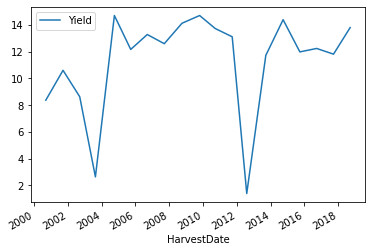

In [3]:
wdf = prepare_weather(get_filepath('champion_weather.txt'))
soil = SoilClass('silt_loam')
crop = CropClass('maize')
model = AquaCropModel('2000/05/01','2018/10/31',wdf,soil,crop)
model.initialize()
model.step(till_termination=True)
final_rainfed = model.Outputs.Final
final_rainfed.plot(x="HarvestDate",y="Yield")

For most years, purely rain-fed irrigation was enough to achive good yields, however, two years in particular (2003, 2012) suffered badly due to lack of rainfall.

The `IrrMngtClass` allows the user to specify an irrigaiton strategy to follow. Uncomment and run the cell below to have a look

In [4]:
#IrrMngtClass??

As you can see, there are 5 different types of irrigaiton strategy specified by the `IrrMethod` argument:

 - `IrrMethod=0` : Rain-fed (no irrigation)
 
 - `IrrMethod=1` : Soil-moisture thresholds (4 SMTs that specify the allowable level of soil moisture, below which, irrigation is triggered. One SMT is used for each major growth stage.)
  
 - `IrrMethod=2` : Specified time interval (irrigate ever N days)
   
 - `IrrMethod=3` : Pre-defined schedule (specified by a pandas DataFrame containing dates and irrigaiton amounts)
    
 - `IrrMethod=4` : Net irrigation (Applies small amounts of water each day when the water content exceeds a given threshold)
 
 - `IrrMethod=5` : Applies a constant irrigation depth each day

For now we will focus on `IrrMethod=1`

In [5]:
# set constant soil moisture target of 50% total available water
irrmngt = IrrMngtClass(IrrMethod=1,SMT=[50]*4)

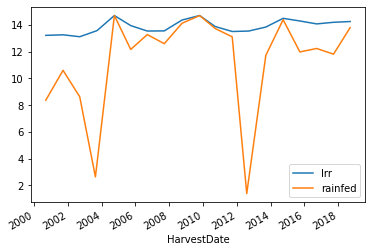

In [6]:
model = AquaCropModel('2000/05/01','2018/10/31',wdf,
                      soil,crop,IrrMngt=irrmngt)
model.initialize()
model.step(till_termination=True)
final_irr = model.Outputs.Final

fig,ax=plt.subplots()
final_irr.plot(x="HarvestDate",y="Yield",label="Irr",legend=True,ax=ax)
final_rainfed.plot(x="HarvestDate",y="Yield",label="rainfed",legend=True,ax=ax)

In [7]:
final_irr

,Season,Name,HarvestDate,Step,Yield,Tirr
0,0,maize,2000-09-13,134,13.212667,300.0
1,1,maize,2001-09-20,506,13.254455,225.0
2,2,maize,2002-09-16,867,13.110659,275.0
3,3,maize,2003-09-24,1240,13.566509,300.0
4,4,maize,2004-10-04,1616,14.695202,50.0
5,5,maize,2005-09-22,1969,13.943056,250.0
6,6,maize,2006-09-15,2327,13.537042,150.0
7,7,maize,2007-09-17,2694,13.547041,200.0
8,8,maize,2008-10-04,3077,14.358981,125.0
9,9,maize,2009-10-20,3458,14.697384,100.0


These results highlight the importance of irrigation, especially during the dry years

## Comparing stratgeies

In the previous example we chose 50% as the soil moisture threshold to follow. But are there better ones. To evaluate this we want to create the crop-water production funciton shown at the top of this notebook. 

In [8]:
def evaluate_smt(smt):
    # create irrmngt class with the chosen SMT
    irrmngt = IrrMngtClass(IrrMethod=1,SMT=[smt]*4)
    
    # run model and return average yield, total irrigaiton over 
    # the simulation period
    model = AquaCropModel('2000/05/01','2018/10/31',wdf,
                      soil,crop,IrrMngt=irrmngt)
    model.initialize()
    model.step(till_termination=True)
    final = model.Outputs.Final
    
    return final.Yield.mean(), final.Tirr.mean()

In [9]:
# create list of thresholds we want to test
smt_list = [i for i in range(0,100,5)]
smt_list

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]

In [10]:
yld_list, tirr_list = [],[]
for smt in smt_list:
    y,t = evaluate_smt(smt)
    yld_list.append(y)
    tirr_list.append(t)

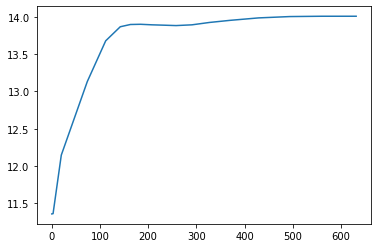

In [11]:
plt.plot(tirr_list,yld_list)

So which strategy is best?

Well if there is no cost to applying more water then you will pick the stratgey with the highest yield.

However, in most cases you will want to balance yield production with costs associated with irrigation. Lets take a simple case of calculating the seasonal profit $P$:

$$P=C*Y - W*I$$

where $C$ is crop selling price; $Y$ is yield; $W$ is water cost; and $I$ is total irrigation applied.

In [15]:
C = 180 # $180 per tonne
W = 2 # $2 per ha-mm

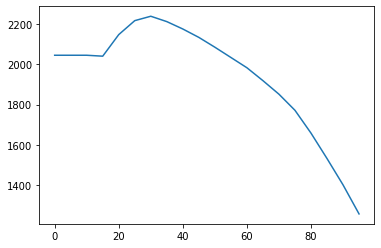

In [16]:
profits = C*np.array(yld_list) - W*np.array(tirr_list)

plt.plot(smt_list,profits)

In [17]:
smt_list[np.argmax(profits)]

30

So in this scenario a soil moisture threshold of 30% TAW is the stratgy that gives the highest profit. 

What happens when you increase/decrease the water price. Which streategy is the best then?

Also we only tested soil moisture targets in steps of 5. Maybe a more thorough search will get a better result?

## So in this tutorial we have learned:

 1) How to specify the irrigaiton strategy in AquaCrop-OSP
 
 2) How to create a crop-water production function to compare irrigation strategies


## Try the next tutorial to see how we can use optimization algorithms to find better irrigaiton strategies faster.